In [1]:
import os, random, time, pymysql
import xgboost
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#from fbprophet import Prophet
from sklearn.linear_model import LinearRegression as LR
from sklearn.kernel_ridge import KernelRidge as KR
from sklearn.linear_model import Ridge, ElasticNet, BayesianRidge, Lars, Lasso
from sklearn.ensemble import RandomForestRegressor as RF

from sklearn.metrics import r2_score
from sklearn.gaussian_process import GaussianProcessRegressor as gpr
from sklearn.gaussian_process.kernels import RBF, DotProduct, WhiteKernel

import warnings

from bayes_opt import BayesianOptimization

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

In [2]:
def _call_db_info(db_name):
    return pymysql.connect(
        host = '10.94.77.9',
        port= 13306,
        user = 'dxbot1',
        password='ensol2020!',
        db = db_name,
        charset = 'utf8')

def h_opt(theta1, g_alpha, k_dot, w_noise, rbf_l, tmp_prev_inven_col, tmp_var_sale_col, tmp_var_product_col):
    prev_inven_col = round(tmp_prev_inven_col)
    var_sale_col, var_product_col = round(tmp_var_sale_col), round(tmp_var_product_col)     
    
    train_set = opt_set[:-4].reset_index(drop=True)
    valid_set = opt_set[-4:].reset_index(drop=True)
    prev_inven_name   = [s for s in train_set.columns.values if 'prev_inven_' in s]    
    var_sale_name     = [s for s in train_set.columns.values if 'sales_prev_' in s]
    var_product_name  = [s for s in train_set.columns.values if 'product_prev_' in s]    
    train_x_name = prev_inven_name[:prev_inven_col]+var_sale_name[:var_sale_col]+var_product_name[:var_product_col]
    kernel =  theta1 * RBF(rbf_l) + WhiteKernel(w_noise)  + DotProduct(k_dot) ## RBF(2) + WhiteKernel(1)  + 
    gp = GaussianProcessRegressor(kernel=kernel, alpha=g_alpha, n_restarts_optimizer=3)
    gp.fit(train_set[train_x_name], train_set['inven'])
    
    train_pred, train_sigma = gp.predict(train_set[train_x_name], return_std=True)
    valid_pred, valid_sigma = gp.predict(valid_set[train_x_name], return_std=True)
    x_pred_ = np.concatenate((train_pred, valid_pred)) 
    y_ = np.concatenate((train_set['inven'], valid_set['inven'])) 

    real_ = np.mean(np.ones_like(train_set['inven']) - np.clip(np.abs(train_set['inven'] - train_pred) / train_set['inven'] , 0, 1)) * 100     
    fcst_ = np.mean(np.ones_like(valid_set['inven']) - np.clip(np.abs(valid_set['inven'] - valid_pred) / valid_set['inven'] , 0, 1)) * 100    
    return fcst_    

In [3]:
dt_sql        = "select * from dt_table"
inven_sql     = "select * from inven_rslt"
prod_plan_sql = "select * from prod_plan"
prod_rslt_sql = "select * from prod_rslt"
prod_prev_sql = "select * from prod_prev"

sale_plan_sql = "select * from sale_plan"
sale_rslt_sql = "select * from sale_rslt"
sale_prev_sql = "select * from sale_prev"

conn = _call_db_info('gscm_e61d')
curs = conn.cursor()
curs.execute(dt_sql) 
dt_table = pd.DataFrame(curs.fetchall())
dt_table.columns = ['ww']
curs.execute("select column_name from information_schema.columns where table_name='inven_rslt' and table_schema='gscm_e61d'")
tmp_col = pd.DataFrame(curs.fetchall())
curs.execute(inven_sql) 
y_inven = pd.DataFrame(curs.fetchall())
y_inven.columns = tmp_col[0].values.tolist()

curs.execute("select column_name from information_schema.columns where table_name='prod_plan' and table_schema='gscm_e61d'")
tmp_col = pd.DataFrame(curs.fetchall())
curs.execute(prod_plan_sql)
prod_plan = pd.DataFrame(curs.fetchall())
prod_plan.columns = tmp_col[0].values.tolist()

curs.execute("select column_name from information_schema.columns where table_name='prod_rslt' and table_schema='gscm_e61d'")
tmp_col = pd.DataFrame(curs.fetchall())
curs.execute(prod_rslt_sql)
prod_rslt = pd.DataFrame(curs.fetchall())
prod_rslt.columns = tmp_col[0].values.tolist()

curs.execute("select column_name from information_schema.columns where table_name='prod_prev' and table_schema='gscm_e61d'")
tmp_col = pd.DataFrame(curs.fetchall())
curs.execute(prod_prev_sql)
prod_prev = pd.DataFrame(curs.fetchall())
prod_prev.columns = tmp_col[0].values.tolist()


curs.execute("select column_name from information_schema.columns where table_name='sale_plan' and table_schema='gscm_e61d'")
tmp_col = pd.DataFrame(curs.fetchall())
curs.execute(sale_plan_sql)
sale_plan = pd.DataFrame(curs.fetchall())
sale_plan.columns = tmp_col[0].values.tolist()

curs.execute("select column_name from information_schema.columns where table_name='sale_rslt' and table_schema='gscm_e61d'")
tmp_col = pd.DataFrame(curs.fetchall())
curs.execute(sale_rslt_sql)
sale_rslt = pd.DataFrame(curs.fetchall())
sale_rslt.columns = tmp_col[0].values.tolist()

curs.execute("select column_name from information_schema.columns where table_name='sale_prev' and table_schema='gscm_e61d'")
tmp_col = pd.DataFrame(curs.fetchall())
curs.execute(sale_prev_sql)
sale_prev = pd.DataFrame(curs.fetchall())
sale_prev.columns = tmp_col[0].values.tolist()


conn.commit()
conn.close()

In [4]:
product_prev = []
tmp_prod_prev_ = [x.split('/') for x in prod_prev['target_ww']]
for i in range(0, prod_prev.shape[0]):
    tmp_ww = prod_prev['ww'].loc[i]
    tmp_s =  dt_table.index[dt_table['ww']==tmp_ww].tolist()[0]#-12
    tmp_split = pd.DataFrame([x.split(':') for x in tmp_prod_prev_[i]])
    tmp_split.columns = ['ww','qty']
    
    tmp_prev_qty = []
    for k in range(1, 13):
        if any(str(dt_table['ww'].loc[tmp_s-k]) == tmp_split['ww']):
            tmp_ind = [i for i, x in enumerate(str(dt_table['ww'].loc[tmp_s-k]) == tmp_split['ww']) if x]    
            tmp_prev_qty.append(float(tmp_split['qty'].loc[tmp_ind].values[0]))
        else:
            tmp_prev_qty.append(0.0)
    tmp_product_prev = prod_prev[['ww','date']].loc[i].values.tolist() + tmp_prev_qty
    product_prev.append(tmp_product_prev)
product_prev = pd.DataFrame(product_prev)
product_prev.columns = ['ww', 'date'] + ['product_prev_'+ str(x) for x in range(1,13)]
product_prev = product_prev.drop(['date'], axis=1)

sales_prev = []
tmp_sale_prev_ = [x.split('/') for x in sale_prev['target_ww']]
for i in range(0, sale_prev.shape[0]):    
    tmp_ww = sale_prev['ww'].loc[i]    
    tmp_s =  dt_table.index[dt_table['ww']==tmp_ww].tolist()[0]#-12
    if len(tmp_sale_prev_[i][0])>0:
        tmp_split = pd.DataFrame([x.split(':') for x in tmp_sale_prev_[i]])    
        tmp_split.columns = ['ww','qty']
        tmp_prev_qty = []
        for k in range(1, 13):
            if any(str(dt_table['ww'].loc[tmp_s-k]) == tmp_split['ww']):
                tmp_ind = [i for i, x in enumerate(str(dt_table['ww'].loc[tmp_s-k]) == tmp_split['ww']) if x]    
                tmp_prev_qty.append(float(tmp_split['qty'].loc[tmp_ind].values[0]))
            else:
                tmp_prev_qty.append(0.0)
        tmp_sales_prev = sale_prev[['ww','date']].loc[i].values.tolist() + tmp_prev_qty
        sales_prev.append(tmp_sales_prev)
    else:
        tmp_sales_prev = sale_prev[['ww','date']].loc[i].values.tolist()
        sales_prev.append(tmp_sales_prev)        
sales_prev = pd.DataFrame(sales_prev)
sales_prev = sales_prev.fillna(0)
sales_prev.columns = ['ww', 'date'] + ['sales_prev_'+ str(x) for x in range(1,13)]
sales_prev = sales_prev.drop(['date'], axis=1)

sales_prev['ww_new'] = [dt_table['ww'].loc[dt_table.index[dt_table['ww']==sales_prev['ww'][x]].tolist()[0]+2] for x in range(0, sales_prev.shape[0])]
sales_prev = sales_prev.drop('ww', axis=1)
tmp_d_set = pd.merge(y_inven, product_prev, how='left', left_on='ww', right_on='ww')
d_set = pd.merge(tmp_d_set, sales_prev, how='inner', left_on='ww', right_on='ww_new')
d_set = d_set.drop('ww_new', axis=1)


In [18]:
current = 202102#np.max(y_inven['ww'].values)

In [19]:
dt_current = (dt_table.index[dt_table['ww'] == current].tolist()[0])-1
pred_ww = dt_table['ww'].loc[dt_current+1:].values.tolist()
opt_set = d_set.iloc[:d_set.index[d_set['ww'] == dt_table.loc[dt_current].values.tolist()[0]][0]+1,:]

warnings.filterwarnings(action='ignore', category=UserWarning)
param_bound = {'theta1' : (0, 10), 'g_alpha' : (0.0,0.99) , 'k_dot' : (0, 100), 'w_noise' : (0.0, 100), 'rbf_l' : (0, 10), 
               'tmp_prev_inven_col' : (1,8), 'tmp_var_sale_col' : (1, 12), 'tmp_var_product_col' : (1, 12)}

product_optimizer = BayesianOptimization(f=h_opt, pbounds=param_bound, verbose=2, random_state=1)
product_optimizer.maximize(init_points=10, n_iter=30)
print(product_optimizer.max['target'])

g_alpha = product_optimizer.max['params']['g_alpha']
k_dot = product_optimizer.max['params']['k_dot']
rbf_l = product_optimizer.max['params']['rbf_l']
theta1 =product_optimizer.max['params']['theta1']
prev_inven_col = round(product_optimizer.max['params']['tmp_prev_inven_col'])
var_product_col = round(product_optimizer.max['params']['tmp_var_product_col'])
var_sale_col = round(product_optimizer.max['params']['tmp_var_sale_col'])
w_noise = product_optimizer.max['params']['w_noise']
print("Prev Inven : %d, Var Sale : %d, Var Product : %d"%(prev_inven_col, var_sale_col, var_product_col))

train_set = opt_set

prev_inven_name   = [s for s in train_set.columns.values if 'prev_inven_' in s]    
var_sale_name     = [s for s in train_set.columns.values if 'sales_prev_' in s]
var_product_name  = [s for s in train_set.columns.values if 'product_prev_' in s]
train_x_name = prev_inven_name[:prev_inven_col]+var_sale_name[:var_sale_col]+var_product_name[:var_product_col]
kernel =  theta1 * RBF(rbf_l) + WhiteKernel(w_noise)  + DotProduct(k_dot) ## RBF(2) + WhiteKernel(1)  + 
gp = GaussianProcessRegressor(kernel=kernel, alpha=g_alpha, n_restarts_optimizer=3)
gp.fit(train_set[train_x_name], train_set['inven'])

train_pred, train_sigma = gp.predict(train_set[train_x_name], return_std=True)
 

|   iter    |  target   |  g_alpha  |   k_dot   |   rbf_l   |  theta1   | tmp_pr... | tmp_va... | tmp_va... |  w_noise  |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  81.6     |  0.4129   |  72.03    |  0.001144 |  3.023    |  2.027    |  2.016    |  3.049    |  34.56    |
|  2        |  77.72    |  0.3928   |  53.88    |  4.192    |  6.852    |  2.431    |  10.66    |  1.301    |  67.05    |
|  3        |  78.84    |  0.4131   |  55.87    |  1.404    |  1.981    |  6.605    |  11.65    |  4.448    |  69.23    |
|  4        |  74.71    |  0.8676   |  89.46    |  0.8504   |  0.3905   |  2.189    |  10.66    |  2.082    |  42.11    |
|  5        |  74.6     |  0.9483   |  53.32    |  6.919    |  3.155    |  5.806    |  10.18    |  1.201    |  75.01    |
|  6        |  73.39    |  0.979    |  74.82    |  2.804    |  7.893    |  1.723    |  5.927    |  10.99    |  29.36    |
|  7        |  82.93    

In [98]:
current_ind = prod_plan.index[prod_plan['ww'] == current].tolist()[0]
for i in range(0,var_product_col):
    #print(prod_plan.loc[current_ind-i])
    tmp_split = [x.split(":") for x in prod_plan['target_ww'].loc[current_ind-i].split("/")]
    tmp_split_df = pd.DataFrame(tmp_split)
    tmp_split_df.columns = ['ww', 'product_prev'+str(i+1)]
    tmp_ww_ind = [tmp_split_df['ww'].values.tolist().index(str(x)) for i, x in enumerate(pred_ww) if str(x) in tmp_split_df['ww'].values]
    tmp_prod_plan_test = tmp_split_df.iloc[tmp_ww_ind,:].reset_index(drop=True)    
    if i == 0 :
        prod_plan_test = tmp_prod_plan_test
    else:
        prod_plan_test = pd.merge(prod_plan_test, tmp_prod_plan_test, how='inner', on='ww')
        
current_ind = sale_plan.index[sale_plan['ww'] == dt_table['ww'].loc[dt_current-2]].tolist()[0]
#current_ind = sale_plan.index[sale_plan['ww'] == current].tolist()[0]
for i in range(0,var_sale_col):
    #print(prod_plan.loc[current_ind-i])
    tmp_split = [x.split(":") for x in sale_plan['target_ww'].loc[current_ind-i].split("/")]
    tmp_split_df = pd.DataFrame(tmp_split)
    tmp_split_df.columns = ['ww', 'sales_prev'+str(i+1)]    
    tmp_split_df['ww'] = [str(dt_table['ww'].loc[dt_table.index[dt_table['ww']==int(tmp_split_df['ww'][x])].tolist()[0]+2]) for x in range(0, tmp_split_df.shape[0])]    
    tmp_ww_ind = [tmp_split_df['ww'].values.tolist().index(str(x)) for i, x in enumerate(pred_ww) if str(x) in tmp_split_df['ww'].values]    
    tmp_sale_plan_test = tmp_split_df.iloc[tmp_ww_ind,:].reset_index(drop=True)      
    if i == 0 :
        sale_plan_test = tmp_sale_plan_test
    else:
        sale_plan_test = pd.merge(sale_plan_test, tmp_sale_plan_test, how='left', on='ww')
test_x = pd.merge(sale_plan_test, prod_plan_test, how='inner', on='ww')
test_x = test_x.astype('float')
test_x = test_x.astype({'ww': 'int'})       

test_inven_init = np.array(train_set[['inven']+['prev_inven_'+str(x) for x in range(1,prev_inven_col)]][train_set['ww']==dt_table['ww'].loc[dt_current]]).reshape(-1)
rslt_set, test_pred, test_sigma = [], [], []
for i in range(0, test_x.shape[0]):    
    tmp_pred_inven_mean, tmp_pred_inven_std = gp.predict(np.concatenate([test_inven_init, test_x.iloc[i,1:]]).reshape(1,-1), return_std=True)
    test_pred.append(tmp_pred_inven_mean[0])
    test_sigma.append(tmp_pred_inven_std[0])
    tmp_rslt = np.concatenate([tmp_pred_inven_mean, test_inven_init, test_x.iloc[i,1:]])
    test_inven_init = np.insert(test_inven_init, 0, tmp_pred_inven_mean)[:prev_inven_col]
    rslt_set.append(tmp_rslt)
rslt_set = pd.DataFrame(rslt_set)
rslt_set['ww'] = test_x['ww']
ww_col = rslt_set.columns[-1:].to_list()
x_col = rslt_set.columns[:-1].to_list()
set_col = ww_col + x_col
rslt_set = rslt_set[set_col]
rslt_set.columns = list(['ww','pred_inven'])+train_x_name #total_set.columns

tmp_train_set = train_set[['ww','inven']].copy()
tmp_train_set['inven_pred'] = train_pred
tmp_train_set.head()
tmp_test_set = pd.DataFrame({'ww' :  pred_ww[:len(test_pred)], 
                             'inven' : np.repeat(-999, len(test_pred)),
                             'inven_pred' : test_pred})
tmp_day_set = pd.concat([tmp_train_set, tmp_test_set])
tmp_day_set = tmp_day_set.reset_index(drop=True)

tmp_train_sale = pd.merge(train_set['ww'], sale_rslt[['ww','sale']], how='inner', on='ww')
tmp_test_sale = pd.DataFrame([x.split(':') for x in sale_plan['target_ww'][sale_plan['ww']==current].values.tolist()[0].split('/')])
tmp_test_sale.columns = ['ww', 'sale']
tmp_sale = pd.concat([tmp_train_sale, tmp_test_sale])
tmp_sale = tmp_sale.astype({'ww': 'int'})  
day_set = pd.merge(tmp_day_set, tmp_sale, how='inner', on='ww')
day_set = day_set.astype({'sale' : 'float'})

day_set_nonzero = day_set.copy()
sale_col = np.where(day_set_nonzero.columns.values =='sale')[0][0]
for i in range(0, day_set_nonzero.shape[0]):
    tmp_ids = i-1 if i-1 > 0 else 0    
    if day_set_nonzero['sale'].loc[i] == 0:        
        day_set_nonzero.iloc[i, sale_col] = day_set_nonzero.iloc[tmp_ids, sale_col]
        #day_set_nonzero.['sale'].loc[i] = day_set_nonzero['sale'].loc[tmp_ids]
        

inven_d = []
for i in range(0, day_set_nonzero.shape[0]):
    if i > 0 and i < day_set_nonzero.shape[0]-3:
        tmp_sale_avg = np.mean(day_set_nonzero['sale'][i:(i+4)].values)
        if i < day_set_nonzero[day_set_nonzero['ww'] == current].index[0] :
            tmp_inven = day_set_nonzero['inven'][i-1]    
        else:
            tmp_inven = day_set_nonzero['inven_pred'][i-1]    
        inven_d.append(round(tmp_inven / tmp_sale_avg * 6.76,1))
    else:
        inven_d.append(0)
        
day_set_nonzero['inven_d'] = inven_d      


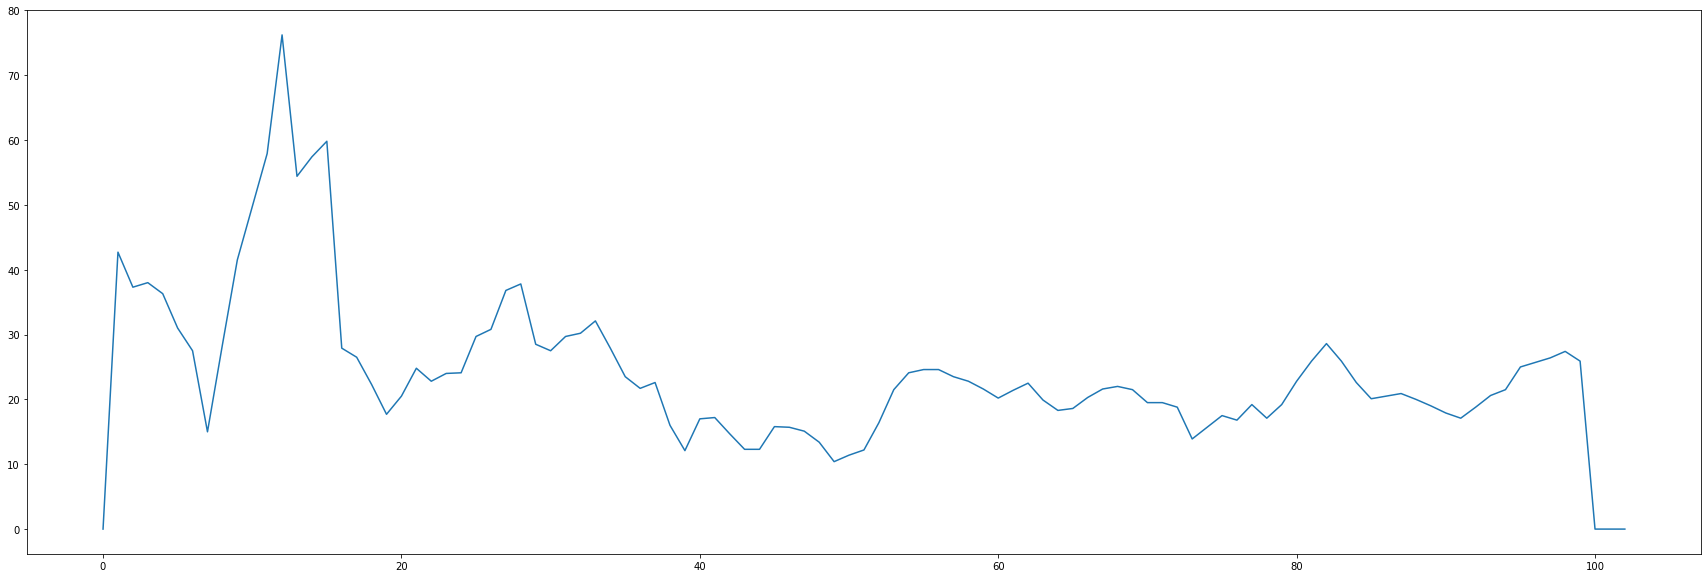

In [101]:
plt.figure(figsize=(30,10))
plt.plot(day_set_nonzero['inven_d'])

,ww,date,inven,prev_inven_1,prev_inven_2,prev_inven_3,prev_inven_4,prev_inven_5,prev_inven_6,prev_inven_7,prev_inven_8
0,202001,2020-01-05,629709,704804,660010,548225,453382,402367,514039,503889,583257
1,202002,2020-01-12,649121,629709,704804,660010,548225,453382,402367,514039,503889
2,202003,2020-01-19,595718,649121,629709,704804,660010,548225,453382,402367,514039
3,202004,2020-01-26,561899,595718,649121,629709,704804,660010,548225,453382,402367
4,202005,2020-02-02,592359,561899,595718,649121,629709,704804,660010,548225,453382
...,...,...,...,...,...,...,...,...,...,...,...
64,202112,2021-03-28,1111362,1246419,1230948,1154057,1215380,1174008,1040573,948104,819596
65,202113,2021-04-04,1160150,1111362,1246419,1230948,1154057,1215380,1174008,1040573,948104
66,202114,2021-04-11,1193339,1160150,1111362,1246419,1230948,1154057,1215380,1174008,1040573
67,202115,2021-04-18,1002560,1193339,1160150,1111362,1246419,1230948,1154057,1215380,1174008
